In [1]:
import re

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt

import pandas as pd

import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from collections import Counter

from string import punctuation
import csv


# Preparing and Analyzing the data

In [2]:
# load train data
train_data = pd.read_csv('data/train.csv', encoding = "ISO-8859-1")
train_data.columns = ['id','label','text']
train_data = train_data.drop(['id'],axis=1)

In [3]:
positives = train_data['label'][train_data.label == 0]
negatives = train_data['label'][train_data.label == 1]
print('Number of positve sentences is:  {}'.format(len(positives)))
print('Number of negative sentences is: {}'.format(len(negatives)))
print('Total length of the data is:     {}'.format(train_data.shape[0]))

Number of positve sentences is:  43532
Number of negative sentences is: 56457
Total length of the data is:     99989


In [4]:
def word_count(sentence):
    return len(sentence.split())

train_data['word count'] = train_data['text'].apply(word_count)
train_data.head(3)

,label,text,word count
0,0,is so sad for my APL frie...,7
1,0,I missed the New Moon trail...,6
2,1,omg its already 7:30 :O,5


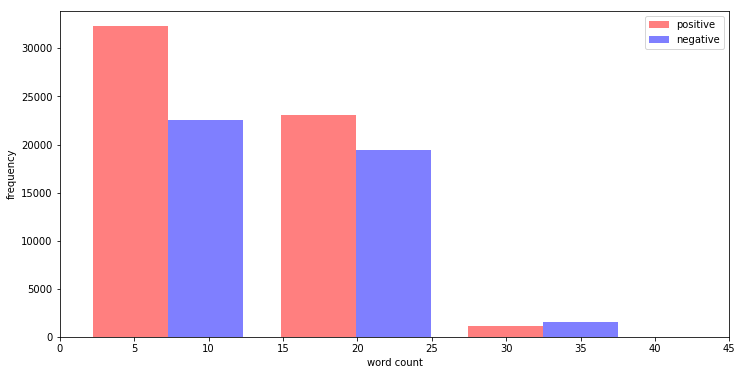

In [5]:

x = train_data['word count'][train_data.label == 1]
y = train_data['word count'][train_data.label == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y], color=['r','b'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [6]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet


In [7]:
#transforms slang words to normal
fileName = "slang.txt"
accessMode = "r"
myCSVfile = open(fileName, accessMode)
dataFromFile = csv.reader(myCSVfile, delimiter="=")
def slang_translator(user_string):
    user_string = user_string.split(" ")
    j = 0
    for _str in user_string:
            # Reading file as CSV with delimiter as "=", so that abbreviation are stored in row[0] and phrases in row[1]
            # Removing Special Characters.
            _str = re.sub('[^a-zA-Z0-9-_.]', '', _str)
            for row in dataFromFile:
                # Check if selected word matches short forms[LHS] in text file.
                if _str.upper() == row[0]:
                    # If match found replace it with its appropriate phrase in text file.
                    user_string[j] = row[1]
            j = j + 1
    # Replacing commas with spaces for final output.
    return (' '.join(user_string))

In [8]:
train_data['text'] = train_data['text'].apply(processTweet)
train_data['text'] = train_data['text'].apply(slang_translator)
train_data = train_data.drop_duplicates('text')
# preview some cleaned tweets
myCSVfile.close()

In [9]:
all_words = []
for line in list(train_data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
    
Counter(all_words).most_common(10)

[('the', 29607),
 ('you', 28916),
 ('and', 16387),
 ('that', 13522),
 ('for', 12339),
 ('have', 9908),
 ('but', 9100),
 ('was', 7210),
 ('not', 7171),
 ('just', 6836)]

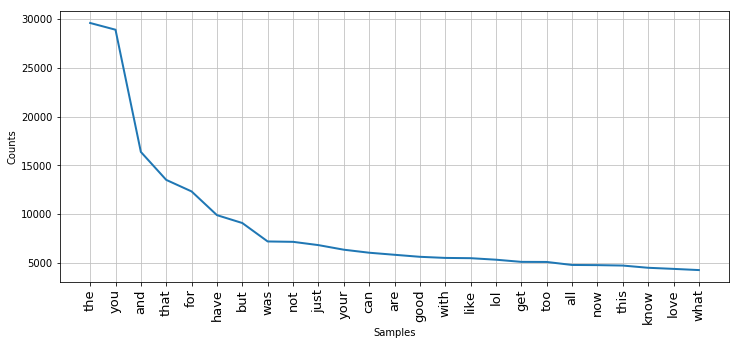

In [10]:
# most common words in twitter dataset
all_words = []
for line in list(train_data['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False)

In [11]:

# tokenize helper function
def text_process(raw_text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    # Returns a list of the cleaned text
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


In [12]:
# tokenize message column and create a column for tokens
train_data['tokens'] = train_data['text'].apply(text_process) # tokenize style 1
train_data.head(2)

,label,text,word count,tokens
0,0,sad for apl friend,7,"[sad, apl, friend]"
1,0,missed the new moon trailer,6,"[missed, new, moon, trailer]"


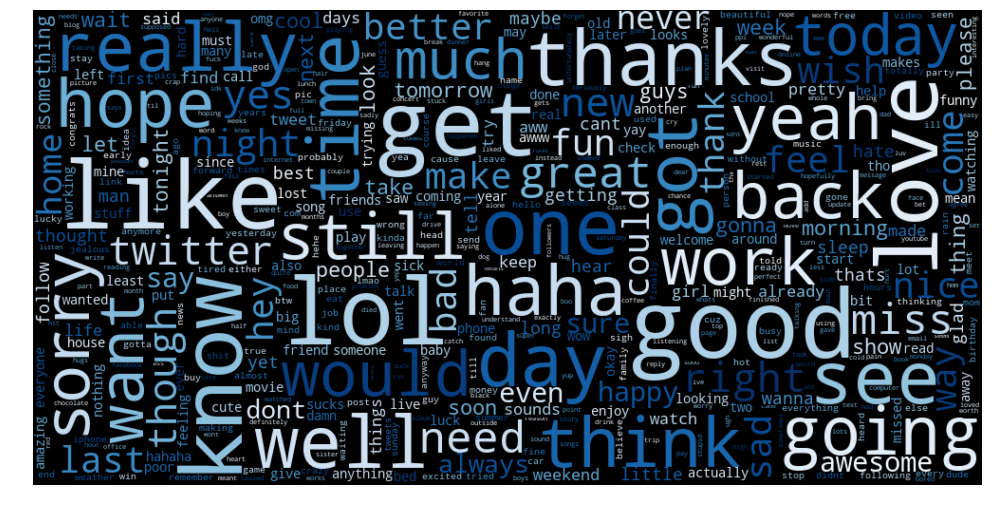

In [13]:
from wordcloud import WordCloud
# split sentences to get individual words
all_words = []
for line in train_data['tokens']: # try 'tokens'
    all_words.extend(line)
    
# create a word frequency dictionary
wordfreq = Counter(all_words)
# draw a Word Cloud with word frequencies
wordcloud = WordCloud(width=1000,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Train Test Split over different preprocessing methods

***Train test split on TEXT CLEANING STAGE***

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['label'], test_size=0.2)

***Train test split on SPELLING CORRECTION PART***

In [18]:
from pattern.en import suggest
suggest("fianlly")

    

RuntimeError: generator raised StopIteration

In [ ]:
X_train_SC, X_test_SC, y_train_SC, y_test_SC = train_test_split(train_data_SC, train_data['label'], test_size=0.2)

***Train test split WORDNET SENSES***

In [ ]:
from nltk.corpus import wordnet as wn

train_data_WN = []

for tweet in train_data['tokens']:
    new_tweet = ''
    for word in tweet:
        new_tweet+=word+' '
        
    for word in tweet: 
        for synset in wn.synsets(word)[:1]:
            for hypernym in synset.hypernyms()[:1]:
                for lemma in hypernym.lemmas()[:1]:
                    new_tweet+=lemma.name() + ' '
            for hyponym in synset.hyponyms()[:1]:
                for lemma in hyponym.lemmas()[:1]:
                    new_tweet+=lemma.name() + ' '
            break
    train_data_WN.append(new_tweet)

In [ ]:
X_train_WN, X_test_WN, y_train_WN, y_test_WN = train_test_split(train_data_WN, train_data['label'], test_size=0.2)

In [ ]:
Results = {}

# METHODS

## Naive-bayes classifier

In [ ]:
# create pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents = 'ascii',
                            stop_words = 'english',
                            lowercase=True,
                           ngram_range=(1,1))),  # strings to token integer counts
    ('tfidf', TfidfTransformer(use_idf=False)),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB(alpha=1e-2)),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

### Naive-bayes classifier on cleaned Data

In [ ]:
pipeline.fit(X_train, y_train)
y_pred_CD = pipeline.predict(X_test)

print('accuracy score: ',accuracy_score(y_test, y_pred_CD))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_pred_CD))
print('\n')
print(classification_report(y_test, y_pred_CD))

Results['naive-bayes'] = {'cleaned data': accuracy_score(y_test, y_pred_CD)}

### Naive-bayes classifier on Spelling Corrected Data

In [ ]:
pipeline.fit(X_train_SC, y_train_SC)
y_preds_SC = pipeline.predict(X_test_SC)

print('accuracy score: ',accuracy_score(y_test_SC, y_preds_SC))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_SC,y_preds_SC))
print('\n')
print(classification_report(y_test_SC, y_preds_SC))

Results['naive-bayes']['spelling corrected'] = accuracy_score(y_test_SC, y_preds_SC)

### Naive-bayes classifier on WordNet senses

In [ ]:
pipeline.fit(X_train_WN, y_train_WN)
y_preds_WN = pipeline.predict(X_test_WN)

print('accuracy score: ',accuracy_score(y_test_WN, y_preds_WN))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_WN,y_preds_WN))
print('\n')
print(classification_report(y_test_WN, y_preds_WN))

Results['naive-bayes']['wordnet senses'] = accuracy_score(y_test_WN, y_preds_WN)

### Naive-bayes classifier Results

In [ ]:
print("Text cleaning: ", accuracy_score(y_test, y_preds_CD))
print("Spelling corrected: ", accuracy_score(y_test_SC, y_preds_SC))
print("WordNet senses added: ", accuracy_score(y_test_WN, y_preds_WN))

## Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

pipeline = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

### Logistic Regression on cleaned Data

In [ ]:
pipeline.fit(X_train, y_train)
y_preds_CD = pipeline.predict(X_test)


print('accuracy score: ',accuracy_score(y_test, y_preds_CD))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds_CD))
print('\n')
print(classification_report(y_test, y_preds_CD))


### Logistic Regression on Spelling Corrected Data

In [ ]:
pipeline.fit(X_train_SC, y_train_SC)
y_preds_SC = pipeline.predict(X_test_SC)

print('accuracy score: ',accuracy_score(y_test_SC, y_preds_SC))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_SC,y_preds_SC))
print('\n')
print(classification_report(y_test_SC, y_preds_SC))

### Logistic Regression on WordNet senses

In [ ]:
pipeline.fit(X_train_WN, y_train_WN)
y_preds_WN = pipeline.predict(X_test_WN)

print('accuracy score: ',accuracy_score(y_test_WN, y_preds_WN))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_WN,y_preds_WN))
print('\n')
print(classification_report(y_test_WN, y_preds_WN))

### Logistic Regression Results

In [ ]:
print("Text cleaning: ", accuracy_score(y_test, y_preds_CD))
print("Spelling corrected: ", accuracy_score(y_test_SC, y_preds_SC))
print("WordNet senses added: ", accuracy_score(y_test_WN, y_preds_WN))

Results['logistic regression'] = {'cleaned data': accuracy_score(y_test, y_preds_CD)}
Results['logistic regression']['spelling corrected'] = accuracy_score(y_test_SC, y_preds_SC)
Results['logistic regression']['wordnet senses'] = accuracy_score(y_test_WN, y_preds_WN)


## SVM

In [ ]:
from sklearn import svm

vec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True, use_idf = True, ngram_range=(1, 2))
svm_clf =svm.LinearSVC(C=0.1)

pipeline = Pipeline([('vectorizer', vec), 
                     ('classifier', svm_clf)])



### SVM on cleaned Data

In [ ]:
pipeline.fit(X_train, y_train)
y_preds_CD = pipeline.predict(X_test)


print('accuracy score: ',accuracy_score(y_test, y_preds_CD))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds_CD))
print('\n')
print(classification_report(y_test, y_preds_CD))


### SVM on Spelling Corrected Data

In [ ]:
pipeline.fit(X_train_SC, y_train_SC)
y_preds_SC = pipeline.predict(X_test_SC)

print('accuracy score: ',accuracy_score(y_test_SC, y_preds_SC))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_SC,y_preds_SC))
print('\n')
print(classification_report(y_test_SC, y_preds_SC))

### SVM on WordNet senses

In [ ]:
pipeline.fit(X_train_WN, y_train_WN)
y_preds_WN = pipeline.predict(X_test_WN)

print('accuracy score: ',accuracy_score(y_test_WN, y_preds_WN))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_WN,y_preds_WN))
print('\n')
print(classification_report(y_test_WN, y_preds_WN))

### SVM Results

In [ ]:
print("Text cleaning: ", accuracy_score(y_test, y_preds_CD))
print("Spelling corrected: ", accuracy_score(y_test_SC, y_preds_SC))
print("WordNet senses added: ", accuracy_score(y_test_WN, y_preds_WN))

Results['SVM'] = {'cleaned data': accuracy_score(y_test, y_preds_CD)}
Results['SVM']['spelling corrected'] = accuracy_score(y_test_SC, y_preds_SC)
Results['SVM']['wordnet senses'] = accuracy_score(y_test_WN, y_preds_WN)


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

vec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True, use_idf = True, ngram_range=(1, 2))
knn_clf = KNeighborsClassifier(n_neighbors=3)

pipeline = Pipeline([('vectorizer', vec), ('classifier', knn_clf)])



### KNN on cleaned Data

In [ ]:
pipeline.fit(X_train, y_train)
y_preds_CD = pipeline.predict(X_test)


print('accuracy score: ',accuracy_score(y_test, y_preds_CD))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds_CD))
print('\n')
print(classification_report(y_test, y_preds_CD))


### KNN on Spelling Corrected Data

In [ ]:
pipeline.fit(X_train_SC, y_train_SC)
y_preds_SC = pipeline.predict(X_test_SC)

print('accuracy score: ',accuracy_score(y_test_SC, y_preds_SC))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_SC,y_preds_SC))
print('\n')
print(classification_report(y_test_SC, y_preds_SC))


### KNN on WordNet senses

In [ ]:
pipeline.fit(X_train_WN, y_train_WN)
y_preds_WN = pipeline.predict(X_test_WN)

print('accuracy score: ',accuracy_score(y_test_WN, y_preds_WN))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_WN,y_preds_WN))
print('\n')
print(classification_report(y_test_WN, y_preds_WN))


### KNN Results

In [ ]:
print("Text cleaning: ", accuracy_score(y_test, y_preds_CD))
print("Spelling corrected: ", accuracy_score(y_test_SC, y_preds_SC))
print("WordNet senses added: ", accuracy_score(y_test_WN, y_preds_WN))

Results['KNN'] = {'cleaned data': accuracy_score(y_test, y_preds_CD)}
Results['KNN']['spelling corrected'] = accuracy_score(y_test_SC, y_preds_SC)
Results['KNN']['wordnet senses'] = accuracy_score(y_test_WN, y_preds_WN)

## Ensemble classifier(Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

vec = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True, use_idf = True, ngram_range=(1, 2))
random_forest_clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)

pipeline = Pipeline([('vectorizer', vec), ('classifier', random_forest_clf)])


### Random Forest on cleaned Data

In [ ]:
pipeline.fit(X_train, y_train)
y_preds_CD = pipeline.predict(X_test)


print('accuracy score: ',accuracy_score(y_test, y_preds_CD))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test,y_preds_CD))
print('\n')
print(classification_report(y_test, y_preds_CD))


### Random Forest on Corrected Data

In [ ]:
pipeline.fit(X_train_SC, y_train_SC)
y_preds_SC = pipeline.predict(X_test_SC)

print('accuracy score: ',accuracy_score(y_test_SC, y_preds_SC))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_SC,y_preds_SC))
print('\n')
print(classification_report(y_test_SC, y_preds_SC))

### Random Forest on WordNet senses

In [ ]:
pipeline.fit(X_train_WN, y_train_WN)
y_preds_WN = pipeline.predict(X_test_WN)

print('accuracy score: ',accuracy_score(y_test_WN, y_preds_WN))
print('\n')
print('confusion matrix: \n',confusion_matrix(y_test_WN,y_preds_WN))
print('\n')
print(classification_report(y_test_WN, y_preds_WN))

### Random Forest Results 

In [ ]:
print("Text cleaning: ", accuracy_score(y_test, y_preds_CD))
print("Spelling corrected: ", accuracy_score(y_test_SC, y_preds_SC))
print("WordNet senses added: ", accuracy_score(y_test_WN, y_preds_WN))

Results['Random Forest'] = {'cleaned data': accuracy_score(y_test, y_preds_CD)}
Results['Random Forest']['spelling corrected'] = accuracy_score(y_test_SC, y_preds_SC)
Results['Random Forest']['wordnet senses'] = accuracy_score(y_test_WN, y_preds_WN)

## CNN

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D


# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 500

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



In [ ]:
model = Sequential()

model.add(Embedding(10000,
                    64,
                    input_length=500))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_test_seq, y_test), callbacks = [checkpoint])

# Results

In [ ]:
global_res = {}
max_cd = 0
max_sc = 0
max_wn = 0
    
for method in Results.items():
    print("Method: ", method[0])
    for prep in method[1].items():
        print("Approach: ", prep[0] + ' - ' + str(prep[1]))
        if(max_cd<prep[1] and prep[0]=='cleaned data'):
            global_res['cleaned data'] = {method[0]: prep[1]}
            max_cd=prep[1]
        if(max_sc<prep[1] and prep[0]=='spelling corrected'):
            global_res['spelling corrected'] = {method[0]: prep[1]}
            max_sc=prep[1]
        if(max_wn<prep[1] and prep[0]=='wordnet senses'):
            global_res['wordnet senses'] = {method[0]: prep[1]}
            max_wn=prep[1]
            
            
    print('\n')
print('Most accurate')
for approach in global_res.items():
    for method in approach[1].items():
        print(approach[0] + ': ' + method[0] + ' - ' + str(method[1]))